

Поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. 
Построим (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, 
что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, 
повысившая число заказов на 7%



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from matplotlib.ticker import FuncFormatter
from datetime import date, timedelta
import holidays
from fbprophet import Prophet
%matplotlib inline

In [2]:
#  Загрузим и посмотрим на данные


df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv')
df

,Дата,Число заказов
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


In [3]:
#  Приведём дату к нужному формату

df['Дата'] = pd.to_datetime(df['Дата'])

In [4]:
#  Уменьшим число заказов в когорте 2020-02-09 так, будто и не было рекламной кампании.
#  По условию в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция. 
#  Исходя из этого считаем, что рост заказов на 7% относится к 2020-02-09(воскресенье)

df.loc[5, 'Число заказов'] = round(df.loc[5, 'Число заказов'] / 1.07)

In [5]:
#  Переименум колонки для работы с Prophet


df = df.rename(columns={'Дата': 'ds', 'Число заказов': 'y'})

In [20]:
# Вкидываем праздники, для их учёта моделькой. 


holidays_dict = holidays.RU(years=(2020))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
9,2020-03-08,День женщин
10,2020-05-01,Праздник Весны и Труда
11,2020-05-09,День Победы
12,2020-06-12,День России
13,2020-11-04,День народного единства


In [21]:
#  Поскольку у нас есть данные по неделям, то и праздники "округлим" к концам недель

#  Функция для изменения дат праздников

def week_start_date(year, week):
    d = date(year, 1, 1)    
    delta_days = d.isoweekday() - 1
    delta_weeks = week
    if year == d.isocalendar()[0]:
        delta_weeks -= 1
    delta = timedelta(days=-delta_days + 6, weeks=delta_weeks)
    return d + delta

In [22]:
#  Функция для применения к колонке с датами

def holidays_in_weeks(col):
    return week_start_date(col.isocalendar()[0], col.isocalendar()[1]).strftime('%Y-%m-%d')

In [23]:
#   Меняем даты

df_holidays.ds = df_holidays.ds.apply(holidays_in_weeks)

In [24]:
df_holidays

#  Ну вот, теперь у нас не точные даты праздников, а последующие за ними воскресенья,
#  которые являются концами недель(предположительно по воскресеньям мы подбиваем продажи за неделю)

,ds,holiday
0,2020-01-05,Новый год
1,2020-01-05,Новый год
2,2020-01-05,Новый год
3,2020-01-05,Новый год
4,2020-01-05,Новый год
5,2020-01-12,Новый год
6,2020-01-12,Православное Рождество
7,2020-01-12,Новый год
8,2020-02-23,День защитника отечества
9,2020-03-08,День женщин


In [25]:
# Проверим модель

predictions = 4

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество

train_df = df[:-predictions]

In [26]:
#  Обратимся к Пророку

m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.fit(train_df)

INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


In [27]:
# Предсказываем 4 недели

future = m.make_future_dataframe(periods=predictions, freq='W')
forecast =m.predict(future)

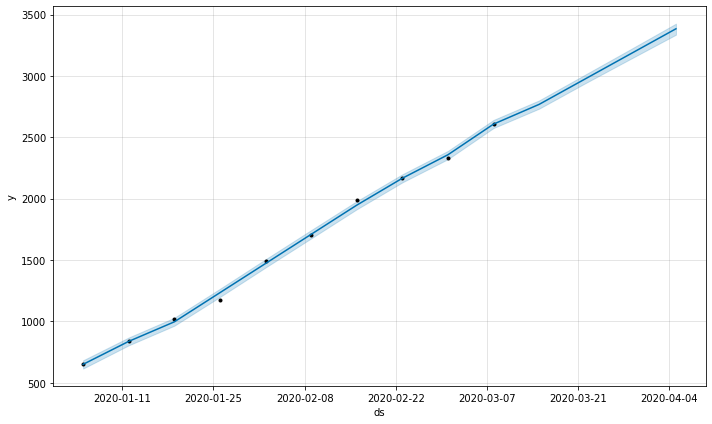

In [28]:
m.plot(forecast);

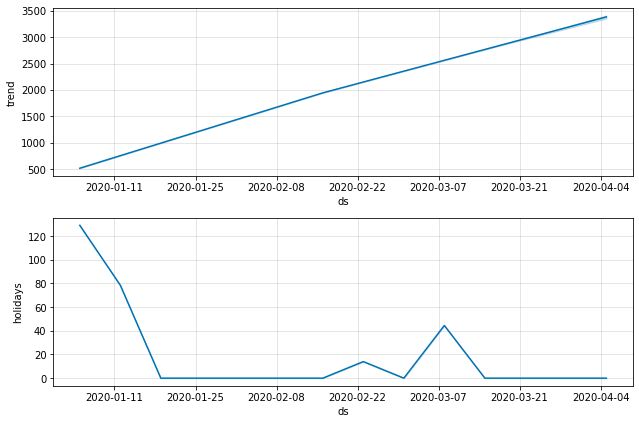

In [29]:
#  А тут можем посмотреть на отдельные компоненты: тренд и праздники 
#  Видим восходящую линию тренда и те праздники, в которые продукты покупают
#  больше: Новый Год, 23-февраля и 8-Марта.

m.plot_components(forecast);

In [30]:
# Смотрим на ошибки модели

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  10.068061146050924 %
MAE (средняя абсолютная ошибка) –  363.87867050073316


In [31]:
# Прогнозируем на полный период (указываем количество недель)

prediction_weeks = 14
final_train_df = df
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_weeks, freq='W')
final_forecast = f.predict(final_future)

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


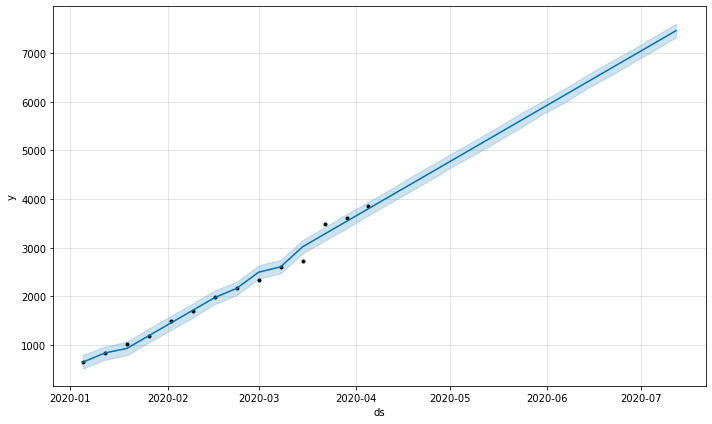

In [32]:
# Смотрим, что предсказалось на полный период

f.plot(final_forecast);

In [33]:
# Рисуем график с границами прогноза

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='prediction'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])



Вывод:
    Prophet отличный инструмент для достаточно точных, а самое главное - быстрых предсказаний временных рядов.
    В данной ситуации ошибка модели 10%, что неплохо, учитывая маленький объём данных для обучения.
    Опираться на данные предсказания конечно нельзя, потому что, если мы посомтрим на факторы, влияющие
    на продажи и их значимость согласно экспертной оценке, то увидим:
        
                        Фактор                                          Экспертная оценка значимости
        
        1. Сезон (-)                                                                100

        2. День недели (-)                                                          80
    
        3. Объём продаж за предыдущие недели (учитывается)                          100
        
        4. Объём продаж за аналогичный период прошлого года (-)                     95
        
        5. Рекламная кампания (учитывается)                                         60
        
        6. Маркетинговые мероприятия (-)                                            40
        
        7. Качество продукции (-)                                                   30
        
        8. Рейтинг бренда (-)                                                       25
        
        9. Отклонение цены от среднерыночной (-)                                    60
           (можно учесть цену продуктовой корзины)
            
        10. Наличие данного товара у конкурентов (-)                                15
        
        
Другими словами: наша модель многих факторов просто не учитывает.
        
Чтобы нашему прогнозу можно было верить, в будущем нужно включить в нашу модель в качестве регрессоров
факторы 1, 4, 6, 9. Ну и фактор 2, конечно, и лучше смотреть по дням.

